# Tensorflow Tutorial @ H2T

# Getting the data ready

First of all, let's import some packages

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

/home/jonasrothfuss/anaconda3/envs/p3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Now we have to download the MNIST datset:

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Understanding the data
The Dataset consists of three parts:
* mnist.train (55 000 images)
* mnist.test (10 000 images)
* mnist.validation  (5 000 images)


Both train and test set are split in to images (28x28) and labels (10 classes - one hot vectors):
* mnist.train.images
* mnist.train.labels

Shape of mnist.train.images: (55000, 784)
Shape of mnist.train.labels: (55000, 10)
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


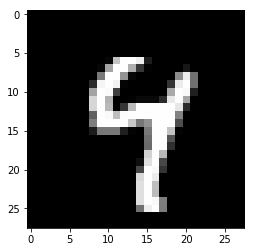

In [3]:
print("Shape of mnist.train.images:", mnist.train.images.shape)
print("Shape of mnist.train.labels:", mnist.train.labels.shape)

# show a sample image
%matplotlib inline
image = mnist.train.images[2].reshape((28,28))
image.shape
plt.imshow(image, cmap='gray')

# show corresponding label (one-hot encoding)
print(mnist.train.labels[2])

# 1. Feeding the Data

<img src="tensorflow_workflow.svg">

To keep it simple we feed the data as numpy array via tf.placeholders:

First, we need to declare a symbolic placeholder variable that hold the images that shall be inputted into the neural network and a placeholder variable for the true labels that come with the dataset

In [4]:
# Define the network input x and the labels y
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, 784]) #shape: (batch_size, width*height)
y = tf.placeholder(tf.float32, [None, 10]) #shape: (batch_size, n_classes)

# Define hyperparameters as placeholders
keep_prob = tf.placeholder_with_default(0.7, ())
learning_rate = tf.placeholder_with_default(0.001, ())

# 2. Define the neural network structure

<img src="tensorflow_workflow2.svg">

Let's think about out neural network model:
* Activations (weights $W$, biases $b$, input $x$, activations $a$)
$$a=Wx+b$$
* Nonlinearity
$$sigm(a) = \frac{1}{1+e^a}$$
* Normalization on the top layer -> Softmax
$$softmax(x)_i=\frac{e^x}{\sum_j e^x}$$
* Loss function -> cross entropy error
$$ L_y(\hat{y}) = - \sum_i y_i * log(\hat{y}_i)$$

In [5]:
#1. layer
layer_size_1 = 30
W_1 = tf.get_variable("W_1", shape=(784, layer_size_1), initializer=tf.initializers.random_normal)
b_1 = tf.get_variable("b_1", shape=(layer_size_1), initializer=tf.initializers.zeros)
a_1 = tf.matmul(x,W_1)+b_1
x_1 = tf.nn.sigmoid(a_1)

#Dropout regularization
x_1 = tf.nn.dropout(x_1, keep_prob=keep_prob)

#2. layer
layer_size_2 = 10 #n_classes
W_2 = tf.get_variable("W_2", shape=(layer_size_1, layer_size_2), initializer=tf.initializers.random_normal)
b_2 = tf.get_variable("b_2", shape=(layer_size_2), initializer=tf.initializers.zeros)
a_2 = tf.matmul(x_1, W_2) + b_2 #logits
y_pred = tf.nn.softmax(a_2) #shape: (batch_size, n_classes)

# Cross entropy loss
# Take the sum of y*log(y_pred) over all classes and then take the average over all instances in the batch
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), reduction_indices=[1]))

#However - for proper implementation use build-in tensorflow function for softmax + cross entropy 
#since this function has better numerical properties
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=a_2, labels=y))


# 3. Define Operations for Execution

<img src="tensorflow_workflow3.svg">

Now we have should train the network. Therefore we have to set up the optimizer operation.

In [6]:
# We recommend to use the adaptive learning rate method ADAM instead of plain Stochastic Gradient Decent since it
# usually converges way faster
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

We should also be able to track if the training is goinig well. Therefore we define the accuracy which we can call later during the training to estimate how well the model performs

In [7]:
# decide if correctly classified (i.e. highest predicted softmax score corresponds to true label)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_pred,1))
# define accuracy 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 4. Execute Network in a Session

<img src="tensorflow_workflow4.svg">

Until now, we have just done some modelling by writing symbolic code, telling the computer how our neural network model looks like and how it should be trained. However, we have not performed a single calculation. Now it is time to actually train the network. Therefore we need to:
1. Start a Session hold the variables and operations - it allows us to run the previously declared operations
2. Initialize the variables (except placeholders)
3. Perform training steps in a loop

In [12]:
# Start Session
sess = tf.InteractiveSession()

# Initialize Variables (W and b Tensors)
tf.global_variables_initializer().run()

# Training Steps
n_train_steps = 10001
batch_size = 100

for i in range(n_train_steps):
    # get training batches from the train dataset
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    loss, _ = sess.run([cross_entropy, train_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.8})
    if i % 1000 == 0:    
        #Run Accuracy computation on the whole test set
        valid_acc = sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0})
        print("Train step %i:"%i,loss, "[%.2f"%(valid_acc*100), "%]")

Train step 0: 6.04844 [11.74 %]
Train step 1000: 0.954829 [75.93 %]
Train step 2000: 0.48428 [85.30 %]
Train step 3000: 0.606314 [88.41 %]
Train step 4000: 0.485841 [89.91 %]
Train step 5000: 0.402054 [91.08 %]
Train step 6000: 0.360479 [91.69 %]
Train step 7000: 0.443763 [92.22 %]
Train step 8000: 0.418975 [92.75 %]
Train step 9000: 0.289638 [93.03 %]
Train step 10000: 0.228719 [93.22 %]


# A CNN model with tf.contrib.slim

In [9]:
import tensorflow.contrib.slim as slim

# define a simle CNN network
def CNN(x, y, is_training=True):
    batch_norm_params = {'is_training': is_training, 'decay': 0.9, 'updates_collections': None}
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                        normalizer_fn=slim.batch_norm,
                        normalizer_params=batch_norm_params):
        x = tf.reshape(x, [-1, 28, 28, 1])

        # For slim.conv2d, default argument values are like
        # normalizer_fn = None, normalizer_params = None, <== slim.arg_scope changes these arguments
        # padding='SAME', activation_fn=nn.relu,
        # weights_initializer = initializers.xavier_initializer(),
        # biases_initializer = init_ops.zeros_initializer,
        net = slim.conv2d(x, 32, [5, 5], scope='conv1')
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.conv2d(net, 64, [5, 5], scope='conv2')
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.flatten(net, scope='flatten3')

        # For slim.fully_connected, default argument values are like
        # activation_fn = nn.relu,
        # normalizer_fn = None, normalizer_params = None, <== slim.arg_scope changes these arguments
        # weights_initializer = initializers.xavier_initializer(),
        # biases_initializer = init_ops.zeros_initializer,
        net = slim.fully_connected(net, 1024, scope='fc3')
        net = slim.dropout(net, is_training=is_training, scope='dropout3')  # 0.5 by default
        logit = slim.fully_connected(net, 10, activation_fn=None, normalizer_fn=None, scope='fco')
        
        # Softmax Layer + Cross-Entropy-Loss
        y_pred = tf.nn.softmax(logit)
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=y))
        
        # Accuracy
        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_pred,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return y_pred, cross_entropy, accuracy

# Define train operation (Optimizer)
train_op = tf.train.AdamOptimizer().minimize(cross_entropy)

In [10]:
# Start Session
sess = tf.InteractiveSession()
y_pred, cross_entropy, accuracy = CNN(x, y)

# Initialize Variables (W and b Tensors)
tf.global_variables_initializer().run()

# Training Steps
n_train_steps = 50
batch_size = 100

for i in range(n_train_steps):
    # get training batches from the train dataset
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    loss, _, acc = sess.run([cross_entropy, train_op, accuracy], feed_dict={x: batch_x, y: batch_y})
    if i % 5 == 0:
        print("Train step %i:"%i,loss, "[%.2f]"%acc)

Train step 0: 3.27526 [0.13]
Train step 5: 2.81625 [0.19]
Train step 10: 3.40216 [0.05]
Train step 15: 2.97665 [0.07]
Train step 20: 3.18085 [0.09]
Train step 25: 2.91839 [0.11]
Train step 30: 3.28298 [0.09]
Train step 35: 3.0285 [0.13]
Train step 40: 3.25974 [0.09]
Train step 45: 3.10605 [0.14]
